In [8]:
%matplotlib inline

In [2]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import requests
import time
import os
import datetime
import json
import csv
import hvplot.pandas
import scipy.stats as stats
import geopandas as gpd
import geoviews as gv
from geoviews.tile_sources import OSM
import seaborn as sns
import holoviews as hv
hv.extension('bokeh', 'matplotlib')
from pathlib import Path
from pprint import pprint

# Ontime flight data predictions

In [5]:
# Load the CSV file into a DataFrame
ontime_df = pd.read_csv('data/ontime.csv')

ontime_df.head()

,Date,Date.1,Los Angeles Airport,Dallas Fort Worth Airport,Denver Airport,Melbourne Airport
0,0,2025-01-01,0.753282,0.814210,0.793474,0.793335
1,1,2025-01-02,0.717841,0.788065,0.769100,0.766417
2,2,2025-01-03,0.698538,0.777887,0.761990,0.756239
3,3,2025-01-04,0.771525,0.822142,0.803177,0.792530
4,4,2025-01-05,0.653090,0.778797,0.710443,0.757149


In [6]:
# Drop the "Date" and "Date.1" columns and calculate the mean for the remaining columns
mean_values = ontime_df.drop(columns=['Date', 'Date.1']).mean()

# Display the mean values
print(mean_values)

# Extract the relevant columns
la_ontime = ontime_df['Los Angeles Airport']
dallas_ontime = ontime_df['Dallas Fort Worth Airport']
denver_ontime = ontime_df['Denver Airport']
melbourne_ontime = ontime_df['Melbourne Airport']

# Perform a one-way ANOVA test to check for statistical differences
f_statistic, p_value = stats.f_oneway(la_ontime, 
                                      dallas_ontime, 
                                      denver_ontime, 
                                      melbourne_ontime)

# Display the results
print(f"F-Statistic: {f_statistic}, P-Value: {p_value}")

Los Angeles Airport          0.765341
Dallas Fort Worth Airport    0.808250
Denver Airport               0.818672
Melbourne Airport            0.791444
dtype: float64
F-Statistic: 101.3218698056186, P-Value: 1.4396639574560608e-59


One-way ANOVA appears to show significant difference between the mean values for the airport predicted on time flights.

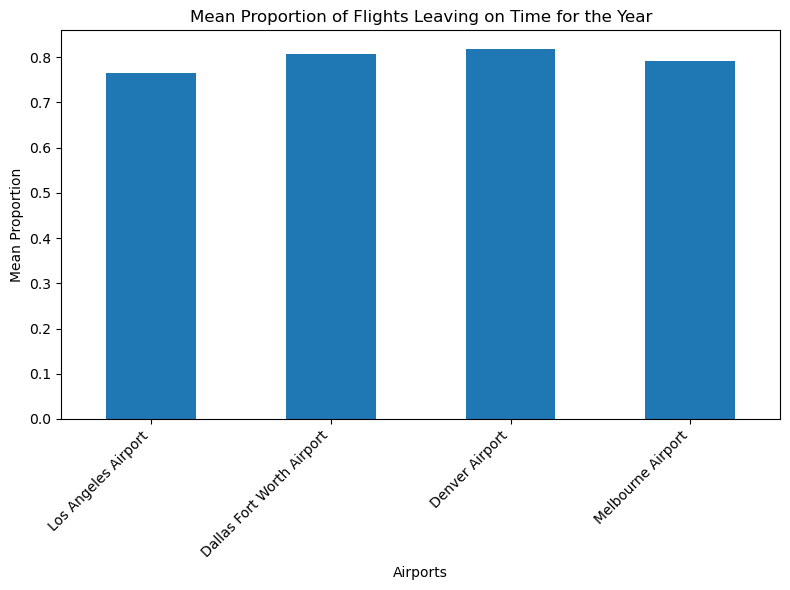

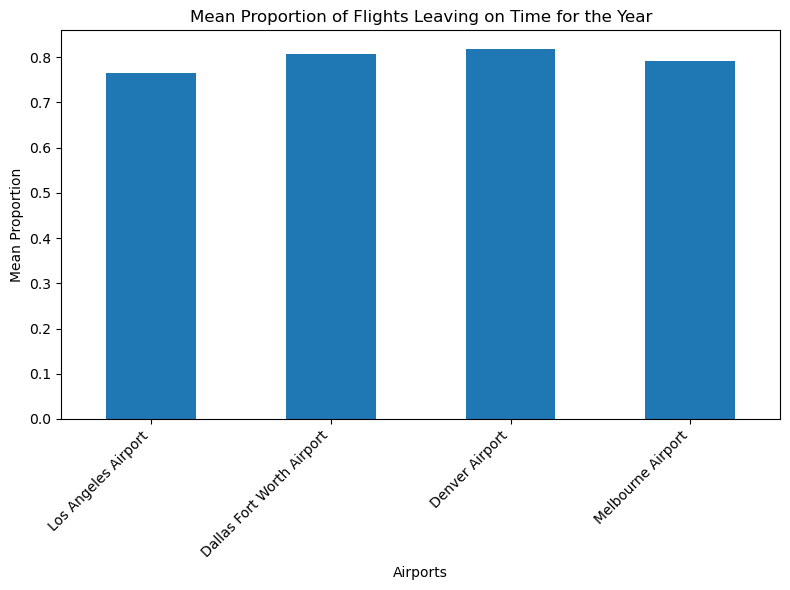

In [9]:
# Create a bar chart
plt.figure(figsize=(8, 6))
mean_values.plot(kind='bar')

# Add labels and title
plt.title('Mean Proportion of Flights Leaving on Time for the Year')
plt.xlabel('Airports')
plt.ylabel('Mean Proportion')

# Rotate the x-axis labels by 45 degrees to the left
plt.xticks(rotation=45, ha='right')

# save graph
output_path = 'output/mean_flights_ontime.png'
plt.savefig(output_path)

# Display the bar chart
plt.tight_layout()
plt.show()

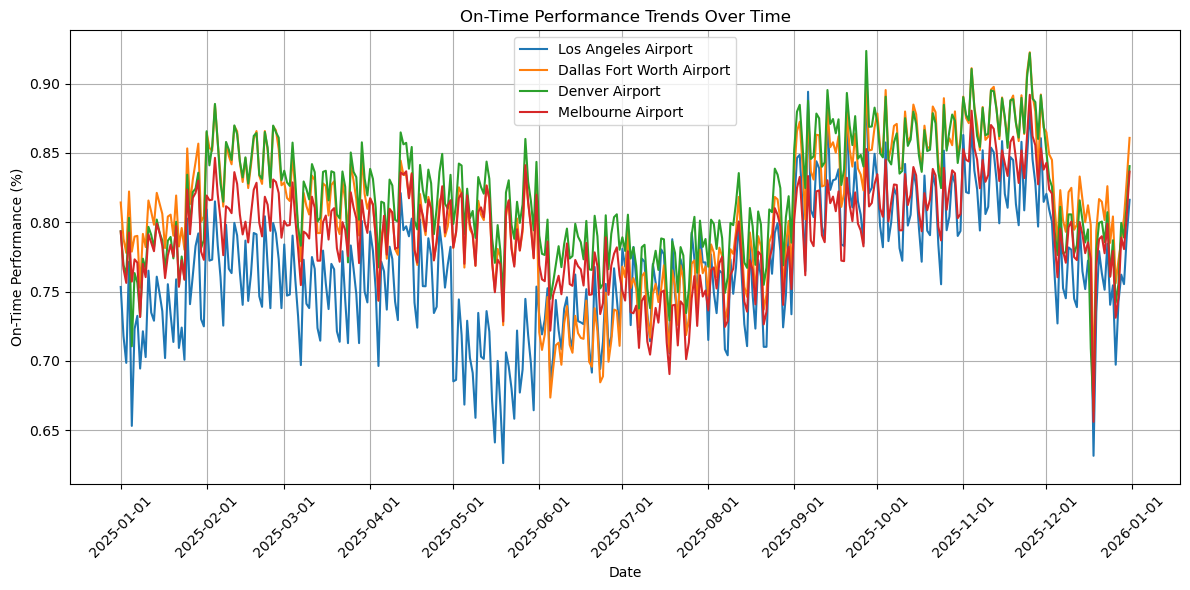

In [10]:
# Convert 'Date.1' to datetime for time series analysis
ontime_df['Date.1'] = pd.to_datetime(ontime_df['Date.1'], errors='coerce')

# Set 'Date.1' as index for easier plotting
ontime_complete = ontime_df.set_index('Date.1')

# Plotting on-time performance trends for each airport over time
plt.figure(figsize=(12, 6))
plt.plot(ontime_complete.index, ontime_complete['Los Angeles Airport'], label='Los Angeles Airport')
plt.plot(ontime_complete.index, ontime_complete['Dallas Fort Worth Airport'], label='Dallas Fort Worth Airport')
plt.plot(ontime_complete.index, ontime_complete['Denver Airport'], label='Denver Airport')
plt.plot(ontime_complete.index, ontime_complete['Melbourne Airport'], label='Melbourne Airport')

# Formatting the date on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Adjust the frequency of x-axis labels

plt.title('On-Time Performance Trends Over Time')
plt.xlabel('Date')
plt.ylabel('On-Time Performance (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# save graph
output_path = 'output/flights_ontime_daily.png'
plt.savefig(output_path)


plt.tight_layout()
plt.show()

In [11]:
# convert the dates to YYYY-MM
# Remove the 'Date' column and adjust 'Date.1' to display months only
month_ontime_df = ontime_df.drop(columns=['Date'])
month_ontime_df['Date.1'] = pd.to_datetime(month_ontime_df['Date.1']).dt.to_period('M')
month_ontime_df['Date.1'] = pd.to_datetime(month_ontime_df['Date.1'].astype(str), format='%Y-%m').dt.strftime('%m')
month_ontime_df.rename(columns={'Date.1': 'Month in 2025'}, inplace=True)

# Mapping month numbers to month names
month_mapping = {
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
}

# Group the data by "Month in 2025" and calculate the mean for each group
month_grouped_df = month_ontime_df.groupby('Month in 2025').mean()

# Rename the index of the grouped DataFrame using the month_mapping dictionary
month_grouped_df.index = month_grouped_df.index.map(month_mapping)

# Display the updated grouped DataFrame
print(month_grouped_df.head())

               Los Angeles Airport  Dallas Fort Worth Airport  Denver Airport  \
Month in 2025                                                                   
Jan                       0.734646                   0.803533        0.782760   
Feb                       0.772723                   0.849022        0.849744   
Mar                       0.750680                   0.815671        0.823941   
Apr                       0.767367                   0.801629        0.822636   
May                       0.696721                   0.794207        0.811360   

               Melbourne Airport  
Month in 2025                     
Jan                     0.781074  
Feb                     0.811140  
Mar                     0.795350  
Apr                     0.802156  
May                     0.793746  


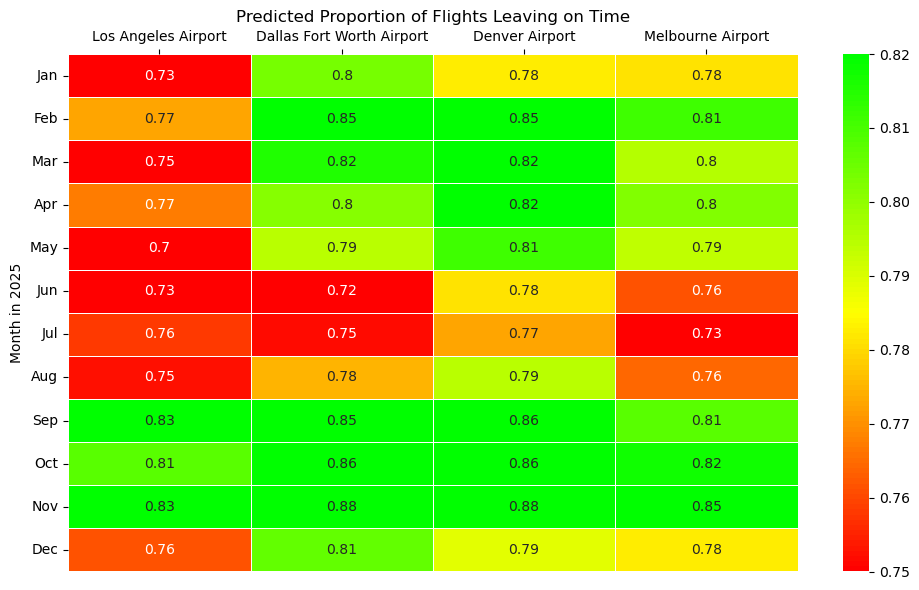

In [12]:
# creating a heat map ** needed GPT help with this **

# Create a red to green gradient with 75% as red and 82% as green
colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0)]  # Red -> Yellow -> Green
n_bins = 100  # Use 100 bins for color scaling
cmap = LinearSegmentedColormap.from_list('RedGreen', colors, N=n_bins)

# Plot heatmap for the grouped data
plt.figure(figsize=(10, 6))
ax = sns.heatmap(month_grouped_df[['Los Angeles Airport', 'Dallas Fort Worth Airport', 'Denver Airport', 'Melbourne Airport']],
            annot=True, cmap=cmap, vmin=0.75, vmax=0.82, linewidths=0.5)

# Add title and labels
plt.title('Predicted Proportion of Flights Leaving on Time')
plt.ylabel('Month in 2025')
plt.yticks(rotation=0)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# save output
output_path = 'output/heatmap_flights_ontime.png'
plt.savefig(output_path)

# Display the heatmap
plt.tight_layout()
plt.show()

In [15]:
# convert the dates to YYYY-MM
# Remove the 'Date' column and adjust 'Date.1' to display months only
month_ontime_df = ontime_df.drop(columns=['Date'])
month_ontime_df['Date.1'] = pd.to_datetime(month_ontime_df['Date.1']).dt.to_period('M')
month_ontime_df['Date.1'] = pd.to_datetime(month_ontime_df['Date.1'].astype(str), format='%Y-%m').dt.strftime('%m')
month_ontime_df.rename(columns={'Date.1': 'Month in 2025'}, inplace=True)

# Mapping month numbers to month names
month_mapping = {
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
}

# Group the data by "Month in 2025" and calculate the mean for each group
month_grouped_df = month_ontime_df.groupby('Month in 2025').mean()

# Rename the index of the grouped DataFrame using the month_mapping dictionary
month_grouped_df.index = month_grouped_df.index.map(month_mapping)

# Display the updated grouped DataFrame
print(month_grouped_df.head())

               Los Angeles Airport  Dallas Fort Worth Airport  Denver Airport  \
Month in 2025                                                                   
Jan                       0.734646                   0.803533        0.782760   
Feb                       0.772723                   0.849022        0.849744   
Mar                       0.750680                   0.815671        0.823941   
Apr                       0.767367                   0.801629        0.822636   
May                       0.696721                   0.794207        0.811360   

               Melbourne Airport  
Month in 2025                     
Jan                     0.781074  
Feb                     0.811140  
Mar                     0.795350  
Apr                     0.802156  
May                     0.793746  


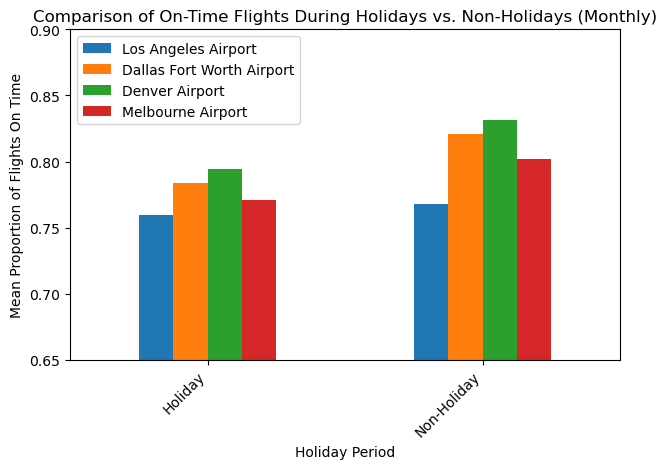

In [18]:
# Charting for differences in Holiday seasons
holiday_months = ['04', '07', '08', '12']  

# Classify each month as "Holiday" or "Non-Holiday"
month_ontime_df['Holiday Period'] = month_ontime_df['Month in 2025'].apply(lambda x: 'Holiday' if x in holiday_months else 'Non-Holiday')

# Select only numeric columns for analysis
numeric_cols = month_ontime_df.select_dtypes(include='number')

# Group by 'Holiday Period' and calculate means only for numeric columns
holiday_analysis = month_ontime_df.groupby('Holiday Period')[numeric_cols.columns].mean()

# Plot the results again
holiday_analysis[['Los Angeles Airport', 'Dallas Fort Worth Airport', 'Denver Airport', 'Melbourne Airport']].plot(kind='bar')

# labels
plt.title('Comparison of On-Time Flights During Holidays vs. Non-Holidays (Monthly)')
plt.xlabel('Holiday Period')
plt.ylabel('Mean Proportion of Flights On Time')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left')
plt.ylim([0.65, 0.9])

# save output
output_path = 'output/holiday_vs_non_holiday.png'
plt.savefig(output_path)

# display
plt.tight_layout()
plt.show()


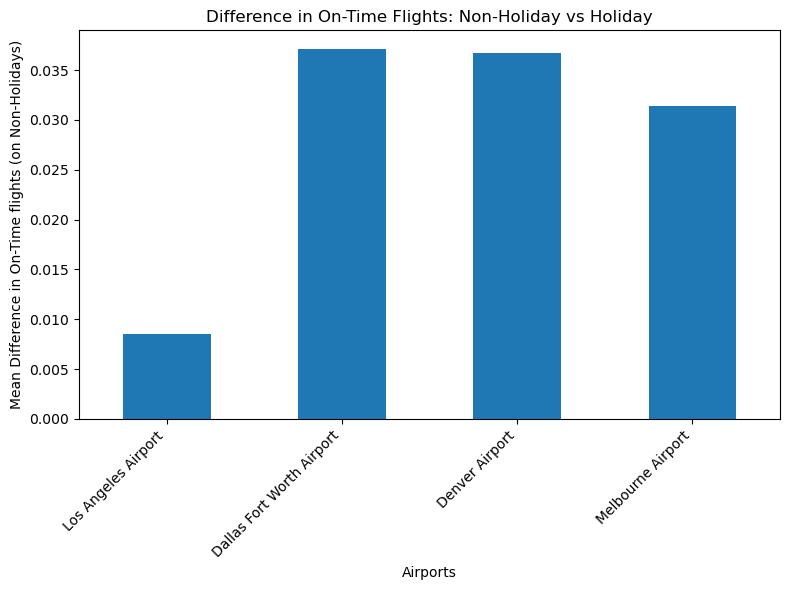

In [19]:
# plot specifically for differences

# Calculate the difference between non-holiday and holiday periods
difference = holiday_analysis.loc['Non-Holiday'] - holiday_analysis.loc['Holiday']

# Plot the difference in a bar chart
plt.figure(figsize=(8, 6))
difference.plot(kind='bar')

# Add labels and title
plt.title('Difference in On-Time Flights: Non-Holiday vs Holiday')
plt.xlabel('Airports')
plt.ylabel('Mean Difference in On-Time flights (on Non-Holidays)')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# save output
output_path = 'output/non_holiday_improvement.png'
plt.savefig(output_path)

# Display the chart
plt.tight_layout()
plt.show()

# Most Frequent Destinations Analysis (2018 Data from API)

In [21]:
# Load the CSV file into a DataFrame
top5dest_df = pd.read_csv('data/top5dest.csv')

# Calculate the frequency of each destination by airport (LA, Dallas, Denver)
la_destinations = top5dest_df[['LA Top Dest', 'LA 2nd Dest', 'LA 3rd dest', 'LA 4th Dest', 'LA 5th Dest']].stack().value_counts()
dallas_destinations = top5dest_df[['Dallas Top Dest', 'Dallas 2nd Dest', 'Dallas 3rd dest', 'Dallas 4th Dest', 'Dallas 5th Dest']].stack().value_counts()
denver_destinations = top5dest_df[['Denver Top Dest', 'Denver 2nd Dest', 'Denver 3rd dest', 'Denver 4th Dest', 'Denver 5th Dest']].stack().value_counts()


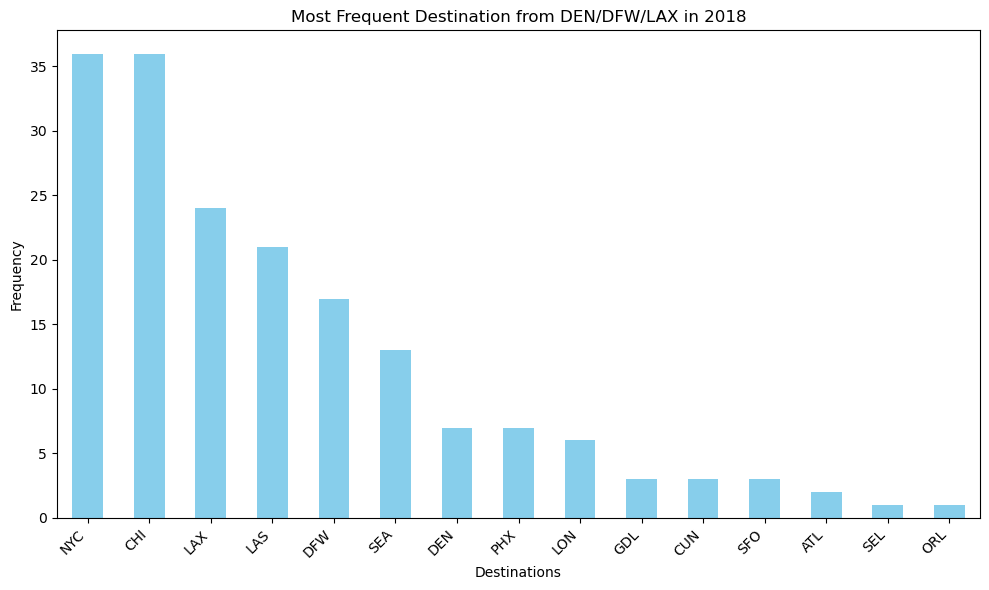

In [22]:
# Concatenate all the destination columns into a single Series to calculate the most frequent destination overall
all_destinations = pd.concat([
    top5dest_df['LA Top Dest'], top5dest_df['LA 2nd Dest'], top5dest_df['LA 3rd dest'], 
    top5dest_df['LA 4th Dest'], top5dest_df['LA 5th Dest'],
    top5dest_df['Dallas Top Dest'], top5dest_df['Dallas 2nd Dest'], 
    top5dest_df['Dallas 3rd dest'], top5dest_df['Dallas 4th Dest'], top5dest_df['Dallas 5th Dest'],
    top5dest_df['Denver Top Dest'], top5dest_df['Denver 2nd Dest'], 
    top5dest_df['Denver 3rd dest'], top5dest_df['Denver 4th Dest'], top5dest_df['Denver 5th Dest']
])

# Visualize the frequency of all destinations in a bar chart
destination_counts = all_destinations.value_counts()

plt.figure(figsize=(10, 6))
destination_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title(f'Most Frequent Destination from DEN/DFW/LAX in 2018')
plt.xlabel('Destinations')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# save output
output_path = 'output/overall_top_dest_2018.png'
plt.savefig(output_path)

# Show the plot
plt.tight_layout()
plt.show()

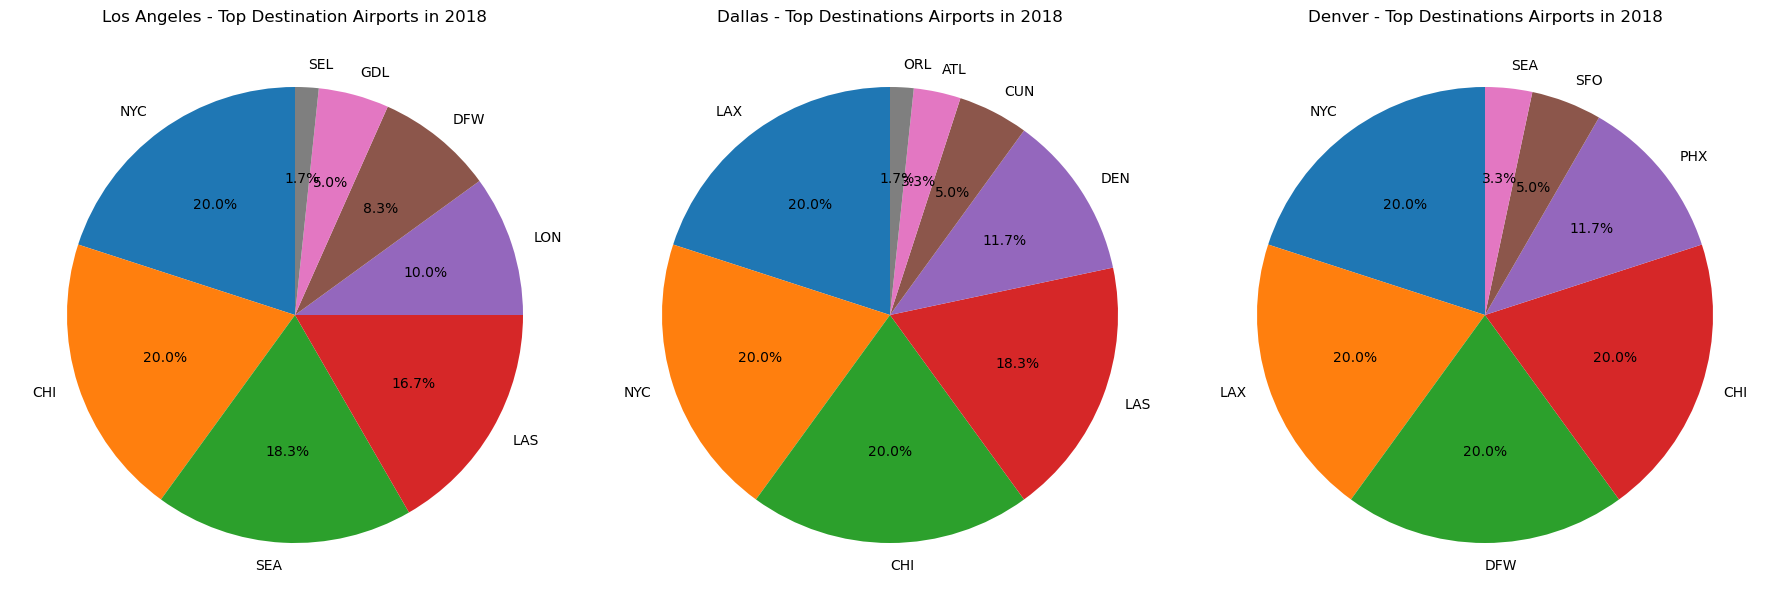

In [23]:
# Create pie charts for each airport's top destinations

# Combine the results into one DataFrame for easier comparison
destination_comparison = pd.DataFrame({
    'Los Angeles': la_destinations,
    'Dallas': dallas_destinations,
    'Denver': denver_destinations
}).fillna(0)  

# Creating a single figure with 3 pie charts side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Los Angeles Pie Chart
axs[0].pie(la_destinations, labels=la_destinations.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Los Angeles - Top Destination Airports in 2018')

# Dallas Pie Chart
axs[1].pie(dallas_destinations, labels=dallas_destinations.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Dallas - Top Destinations Airports in 2018')

# Denver Pie Chart
axs[2].pie(denver_destinations, labels=denver_destinations.index, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Denver - Top Destinations Airports in 2018')

# save output
output_path = 'output/top_dest_2018.png'
plt.savefig(output_path)

# Adjust layout
plt.tight_layout()
plt.show()


In [25]:
# Creation of Map - required GPT to do this ***

# List of origin airports
airport_locations = {
    'LAX': (33.9416, -118.4085),  # Los Angeles
    'DFW': (32.8998, -97.0403),   # Dallas
    'DEN': (39.8561, -104.6737),  # Denver
}

# Extracting destination airports from the dataset
# Stack and combine all destination columns into a single Series
destination_data = pd.concat([
    top5dest_df[['LA Top Dest', 'LA 2nd Dest', 'LA 3rd dest', 'LA 4th Dest', 'LA 5th Dest']].stack().reset_index(drop=True),
    top5dest_df[['Dallas Top Dest', 'Dallas 2nd Dest', 'Dallas 3rd dest', 'Dallas 4th Dest', 'Dallas 5th Dest']].stack().reset_index(drop=True),
    top5dest_df[['Denver Top Dest', 'Denver 2nd Dest', 'Denver 3rd dest', 'Denver 4th Dest', 'Denver 5th Dest']].stack().reset_index(drop=True)
], axis=1)

destination_data.columns = ['LA', 'Dallas', 'Denver']

# Flatten the DataFrame, keeping track of the origin for each destination
flat_destinations = destination_data.stack().reset_index(level=1)
flat_destinations.columns = ['Origin', 'Destination']

# Add more destinations and their coordinates (lat, lon)
destination_coords = {
    'NYC': (40.7128, -74.0060),  # New York
    'LAS': (36.1699, -115.1398), # Las Vegas
    'CHI': (41.8781, -87.6298),  # Chicago
    'SEA': (47.6062, -122.3321), # Seattle
    'PHX': (33.4484, -112.0740), # Phoenix
    'ATL': (33.7490, -84.3880),  # Atlanta
    'CUN': (21.1619, -86.8515),  # Cancún
    'MIA': (25.7617, -80.1918),  # Miami
    'DFW': (32.8998, -97.0403),  # Dallas
    'DEN': (39.8561, -104.6737), # Denver
    'LAX': (33.9416, -118.4085), # Los Angeles
    'GDL': (20.6597, -103.3496), # Guadalajara
    'LON': (51.5074, -0.1278),   # London
    # Add more if needed
}

# Add lat/lon for each destination based on the coordinates provided above
flat_destinations['lat'] = flat_destinations['Destination'].map(lambda x: destination_coords.get(x, (None, None))[0])
flat_destinations['lon'] = flat_destinations['Destination'].map(lambda x: destination_coords.get(x, (None, None))[1])

# Filter out destinations that don't have lat/lon coordinates
flat_destinations = flat_destinations.dropna(subset=['lat', 'lon'])

# Calculate the frequency (popularity) of each destination
destination_frequencies = flat_destinations['Destination'].value_counts()

# Add the frequency (size) to the DataFrame
flat_destinations['size'] = flat_destinations['Destination'].map(destination_frequencies) * 2  # Scale the size by frequency

# Create a GeoDataFrame for the destination points
gdf_destinations = gpd.GeoDataFrame(flat_destinations, 
                                    geometry=gpd.points_from_xy(flat_destinations['lon'], flat_destinations['lat']))

# Use a color map based on the origin airport
color_map = {
    'LA': 'blue',
    'Dallas': 'green',
    'Denver': 'red'
}

# Plot destination airports with color based on the origin airport and size based on frequency
destination_map = gdf_destinations.hvplot.points(geo=True, 
                                                 c='Origin', 
                                                 size='size',  # Size based on frequency
                                                 cmap=color_map, 
                                                 hover_cols=['Destination', 'size'], 
                                                 legend=True)  # Enable legend

# Overlay the destination points on OSM tiles
osm_map = OSM * destination_map

# Display the interactive map with OSM background
hv.save(osm_map, 'output/destination_map_by_origin_with_size_and_legend.html')
osm_map


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Origin,size,Destination)